In [17]:
import networkx as nx
import random
import os
import matplotlib.pyplot as plt
import baseGrafo
from typing import Dict, List, Tuple
from utils import ler_grafo_dimacs, ler_solucoes_otimas, salvar_resultados

vertices:  40 
arestas:  244


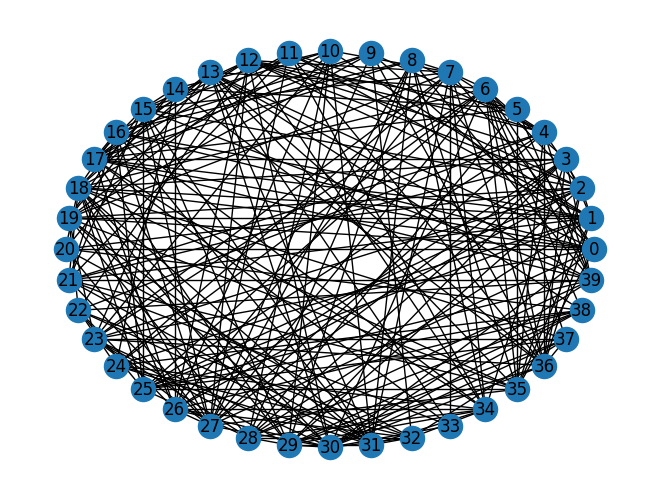

In [18]:
baseGrafo.grafoImport(40)

14849


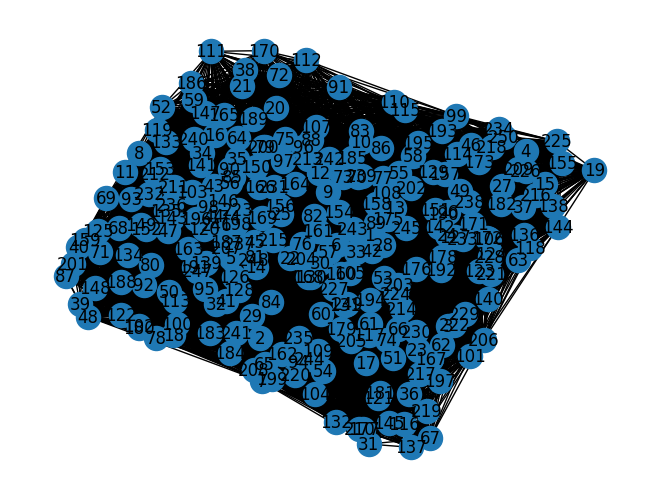

In [19]:
pasta_grafos = "grafos"
resultados_dir = "resultados"
os.makedirs(resultados_dir, exist_ok=True)

solucoes_otimas = ler_solucoes_otimas("solucoes_otimas.csv")

G = ler_grafo_dimacs(os.path.join("grafos", "r250.5.col"))
print(G.number_of_edges())
nx.draw(G, with_labels=True)      

[6, 19, 20, 23, 35, 1, 4, 11, 12, 15, 25, 26, 29, 36]


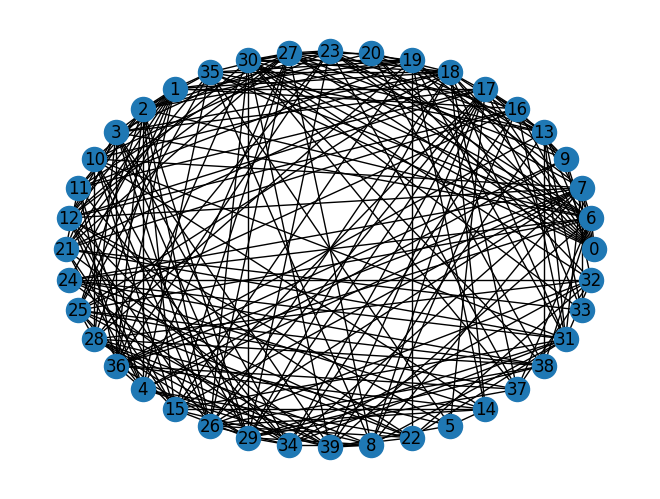

In [20]:
G = nx.read_edgelist("grafoBase.csv", delimiter=",")
G = nx.relabel_nodes(G, lambda x: int(x))
print(list(G.neighbors(2)))

nx.draw_circular(G, with_labels=True)

In [21]:
def calcular_conflitos(G: nx.Graph, coloracao: Dict[int, int]) -> int:
    """Calcula o número de arestas com vértices da mesma cor."""
    conflitos = 0
    for u, v in G.edges():
        if coloracao[u] == coloracao[v]:
            conflitos += 1
    return conflitos

def gerar_vizinhos_otimizado(G: nx.Graph, coloracao: Dict[int, int], n_cores: int) -> List[Tuple[Dict[int, int], Tuple[int, int]]]:
    """Gera vizinhança focando apenas em nós com conflitos, tornando o processo mais rápido."""
    vizinhos = []
    nos_conflitantes = {u for u, v in G.edges() if coloracao[u] == coloracao[v]} | \
                       {v for u, v in G.edges() if coloracao[u] == coloracao[v]}

    if not nos_conflitantes:
        return []

    for v in nos_conflitantes:
        cor_atual = coloracao[v]
        for nova_cor in range(n_cores):
            if nova_cor != cor_atual:
                nova_coloracao = coloracao.copy()
                nova_coloracao[v] = nova_cor
                movimento = (v, nova_cor)
                vizinhos.append((nova_coloracao, movimento))
    return vizinhos

def busca_tabu_coloracao(G: nx.Graph, max_iter: int, tabu_tamanho: int, n_cores: int, solucao_inicial: Dict[int, int]):
    """
    Executa a Busca Tabu para encontrar uma coloração com `n_cores` sem conflitos.
    Inicia a partir de uma `solucao_inicial` fornecida.
    """
    atual = solucao_inicial
    custo_atual = calcular_conflitos(G, atual)
    
    # Se a solução inicial já é válida para n_cores, reatribui cores se necessário
    # Isso garante que as cores estejam no intervalo [0, n_cores-1]
    maior_cor = max(atual.values())
    if maior_cor >= n_cores:
        for v, c in atual.items():
            atual[v] = c % n_cores
        custo_atual = calcular_conflitos(G, atual)

    melhor = atual.copy()
    melhor_custo = custo_atual
    lista_tabu = []

    if melhor_custo == 0:
        return melhor, melhor_custo

    for _ in range(max_iter):
        vizinhos = gerar_vizinhos_otimizado(G, atual, n_cores)
        if not vizinhos: # Se não há mais nós conflitantes
             break
        
        melhor_vizinho = None
        menor_custo = float('inf')
        movimento_escolhido = None

        for vizinho, movimento in vizinhos:
            custo = calcular_conflitos(G, vizinho)
            # Critério de aspiração: permite movimento tabu se ele leva a uma solução melhor que a melhor já vista
            if (movimento not in lista_tabu) or (custo < melhor_custo):
                if custo < menor_custo:
                    melhor_vizinho = vizinho
                    menor_custo = custo
                    movimento_escolhido = movimento
        
        if melhor_vizinho is None:
            break # Não encontrou nenhum movimento válido

        atual = melhor_vizinho
        custo_atual = menor_custo
        
        lista_tabu.append(movimento_escolhido)
        if len(lista_tabu) > tabu_tamanho:
            lista_tabu.pop(0)

        if custo_atual < melhor_custo:
            melhor = atual.copy()
            melhor_custo = custo_atual
            if melhor_custo == 0:
                break

    return melhor, melhor_custo

In [22]:
def otimizar_com_busca_tabu(G: nx.Graph, solucao_inicial: Dict[int, int], k_inicial: int, max_iter: int, tabu_tamanho: int):
    """
    Recebe uma solução gulosa e tenta diminuir o número de cores (k)
    usando a Busca Tabu de forma decremental.
    """
    melhor_k_geral = k_inicial
    melhor_coloracao_geral = solucao_inicial.copy()
    print("-" * 30)
    print(f"Iniciando otimização da Busca Tabu com k = {k_inicial - 1}")
    print("-" * 30)
    
    # Loop decremental: começa de k_inicial - 1 e vai até 1
    for k_alvo in range(k_inicial - 1, 0, -1):
        print(f"\n[Tentativa] Buscando solução com {k_alvo} cores...")
        
        coloracao, conflitos = busca_tabu_coloracao(
            G, max_iter, tabu_tamanho, n_cores=k_alvo, solucao_inicial=melhor_coloracao_geral
        )
        
        if conflitos == 0:
            print(f"  -> SUCESSO! Solução válida encontrada com {k_alvo} cores.")
            melhor_k_geral = k_alvo
            melhor_coloracao_geral = coloracao.copy()
        else:
            print(f"  -> FALHA. Não foi possível encontrar solução com {k_alvo} cores.")
            print("      Parando a busca e retornando a melhor solução anterior.")
            break # Se falhou, não adianta tentar com menos cores

    return melhor_k_geral, melhor_coloracao_geral

40

--- Resultado da Heurística Gulosa ---
Número de cores usado: 7
Conflitos iniciais: 0
------------------------------
Iniciando otimização da Busca Tabu com k = 6
------------------------------

[Tentativa] Buscando solução com 6 cores...
  -> FALHA. Não foi possível encontrar solução com 6 cores.
      Parando a busca e retornando a melhor solução anterior.

--- Resultado Final da Busca Tabu ---
Número mínimo de cores encontrado: 7
Coloração final dos vértices:
[(0, 0), (1, 0), (2, 1), (3, 1), (4, 0), (5, 0), (6, 2), (7, 1), (8, 2), (9, 1), (10, 2), (11, 2), (12, 2), (13, 1), (14, 1), (15, 0), (16, 3), (17, 4), (18, 4), (19, 3), (20, 2), (21, 5), (22, 1), (23, 4), (24, 3), (25, 5), (26, 0), (27, 0), (28, 0), (29, 3), (30, 5), (31, 0), (32, 4), (33, 0), (34, 5), (35, 1), (36, 0), (37, 0), (38, 4), (39, 3)]


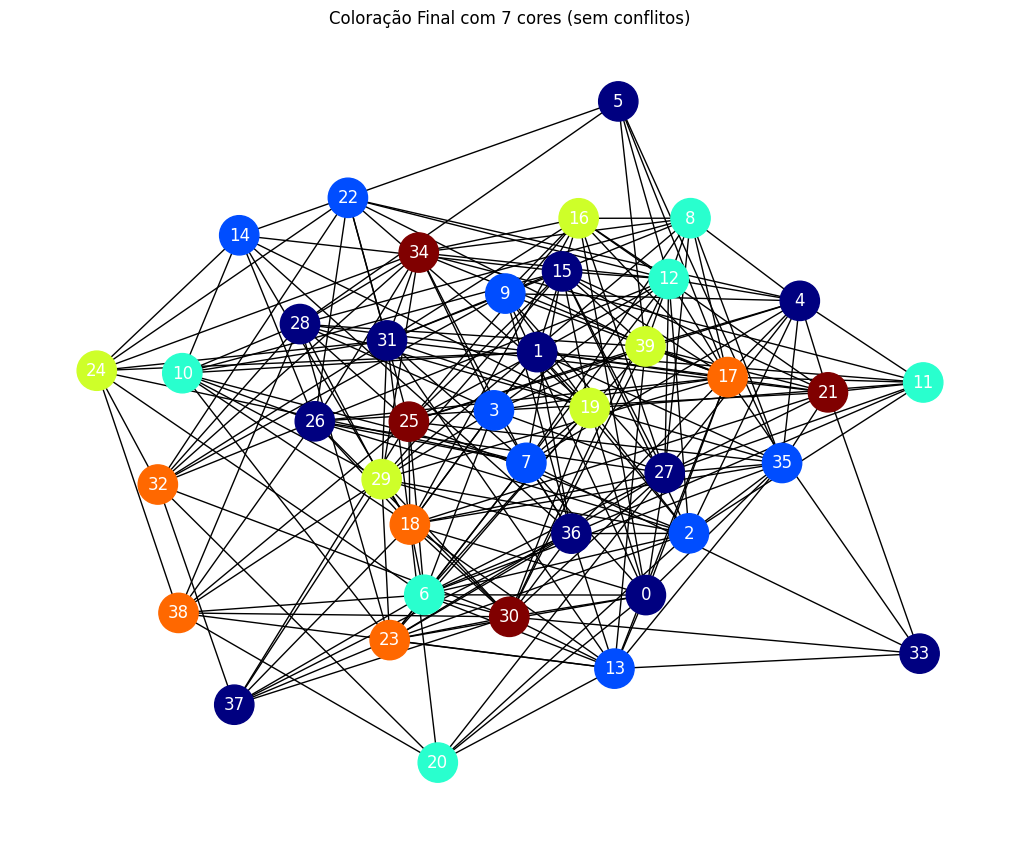

In [23]:
def executar_completo():
    """Orquestra todo o processo de coloração de grafos."""
    # --- Parâmetros ---
    #NUM_VERTICES = 20
    MAX_ITER_TABU = 200
    TAMANHO_LISTA_TABU = 10

    # 1. Gerar o grafo (Apenas caso para teste, agora estamos usando o baseGrafo)
    #G = grafoImport(NUM_VERTICES)


    # 2. Obter solução inicial com heurística gulosa
    solucao_gulosa, k_guloso = baseGrafo.heuristicaGulosa(G)
    conflitos_gulosos = calcular_conflitos(G, solucao_gulosa)
    print("\n--- Resultado da Heurística Gulosa ---")
    print(f"Número de cores usado: {k_guloso}")
    print(f"Conflitos iniciais: {conflitos_gulosos}")

    # 3. Otimizar a solução com a Busca Tabu (estratégia decremental)
    k_final, coloracao_final = otimizar_com_busca_tabu(
        G, solucao_gulosa, k_guloso, MAX_ITER_TABU, TAMANHO_LISTA_TABU
    )

    # 4. Imprimir resultados finais
    print("\n" + "=" * 30)
    print("--- Resultado Final da Busca Tabu ---")
    print(f"Número mínimo de cores encontrado: {k_final}")
    print("Coloração final dos vértices:")
    print(sorted(coloracao_final.items()))

    # 5. Visualização
    pos = nx.spring_layout(G, seed=42)
    cores_map = [coloracao_final.get(v, 0) for v in G.nodes()]
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color=cores_map, cmap=plt.cm.jet, node_size=800, font_color='white')
    plt.title(f'Coloração Final com {k_final} cores (sem conflitos)')
    plt.show()

# Executar tudo
executar_completo()